In [1]:
import pandas as pd
import numpy as np
import mygene
import seaborn as sns
from scipy.stats import randint
import matplotlib.pyplot as plt

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

# 100 Features

## 1. Load & Cleaning Dataset

#### 1.1 Loading in training and prediction datasets

In [2]:
df_2020_gene = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2020LD_pbmc_gene_expression.tsv", sep='\t')
df_2020_specimen = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2020LD_specimen.tsv", sep='\t')
df_2020_subject = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2020LD_subject.tsv", sep='\t')
df_2021_gene = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2021LD_pbmc_gene_expression.tsv", sep='\t')
df_2021_specimen = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2021LD_specimen.tsv", sep='\t')
df_2021_subject = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/training_data/2021LD_subject.tsv", sep='\t')
df_2022_gene = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/prediction_data/2022BD_pbmc_gene_expression.tsv", sep='\t')
df_2022_specimen = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/prediction_data/2022BD_specimen.tsv", sep='\t')
df_2022_subject = pd.read_csv("https://www.cmi-pb.org/downloads/cmipb_challenge_datasets/current/2nd_challenge/raw_datasets/prediction_data/2022BD_subject.tsv", sep='\t')

#### 1.2 Cleaning subject and gene expression datasets

In [3]:
## cleaning the subject/specimen dataset to get an age column
def clean_df_subject(df):
    
    ## Get age column
    df['year_of_birth'] = pd.to_numeric(df['year_of_birth'].str[:4])
    df['date_of_boost'] = pd.to_numeric(df['date_of_boost'].str[:4])
    df['age'] = df['date_of_boost'] - df['year_of_birth']
    return df

In [4]:
## cleaning the gene data to transform ensembl gene id to name
def clean_df_gene(df):
    df['versioned_ensembl_gene_id'] = df['versioned_ensembl_gene_id'].apply(lambda x: x.split('.')[0])
    #mg = mygene.MyGeneInfo()
    
    # extract symbol and gene type from the versioned_ensembl_gene_id
    #df['gene_symbol'] = df['versioned_ensembl_gene_id'].apply(lambda x : mg.getgene(x)['symbol'])
    #df['gene_type'] = df['versioned_ensembl_gene_id'].apply(lambda x : mg.getgene(x)['type_of_gene'])
    return df

In [5]:
#all_genes = genes['versioned_ensembl_gene_id'].unique()
#symbols = []
#for i in all_genes:
#    symbols.append(mg.getgene(i)['symbol'])

#### 1.3 EDA: finding which genes closely relate to CCL3 gene

In [6]:
## concatenating 2020 and 2021 gene datasets
genes = pd.concat([clean_df_gene(df_2020_gene),clean_df_gene(df_2021_gene)]).reset_index()
genes_cols = genes.pivot_table(index=['specimen_id'], columns=['versioned_ensembl_gene_id'], values= 'tpm')#.reset_index()

In [7]:
X = genes_cols.loc[:, genes_cols.columns !='ENSG00000277632']  #independent columns
y = genes_cols['ENSG00000277632']    #target column i.e CCL3

In [8]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                 Specs        Score
32575  ENSG00000234883  2823.158219
29853  ENSG00000230923  1579.290153
56648  ENSG00000280228  1563.466676
19568  ENSG00000203364  1527.484512
51362  ENSG00000271133  1354.239954
49583  ENSG00000267365  1348.884920
31142  ENSG00000232810  1204.898796
3510   ENSG00000108342  1185.819978
34788  ENSG00000238094  1070.072435
39750  ENSG00000251230  1022.311611


In [9]:
top100 = list(featureScores.nlargest(100,'Score')['Specs'])
top100.append('ENSG00000277632')
final_gene = genes_cols[genes_cols.columns.intersection(top100)].rename(columns= {'ENSG00000277632':'CCL3'}).reset_index()
final_gene                                                  

versioned_ensembl_gene_id,specimen_id,ENSG00000081041,ENSG00000087074,ENSG00000099860,ENSG00000100024,ENSG00000100906,ENSG00000101331,ENSG00000105855,ENSG00000108342,ENSG00000123689,...,ENSG00000277969,ENSG00000278546,ENSG00000278869,ENSG00000279065,ENSG00000279719,ENSG00000279907,ENSG00000280159,ENSG00000280228,ENSG00000280587,ENSG00000283265
0,1,80.075,282.700,262.268,1.274,1029.796,0.078,0.451,0.091,1875.568,...,2.892,0.455,2.524,0.0,0.287,0.000,0.331,0.104,0.123,0.000
1,2,57.538,488.817,349.156,1.512,1318.072,0.209,0.594,0.000,3228.718,...,7.612,0.000,5.958,0.0,1.027,0.072,0.445,0.186,0.166,0.000
2,3,91.823,441.602,301.455,1.272,1163.138,0.073,0.657,0.000,1950.863,...,5.238,0.850,2.571,0.0,0.268,0.075,0.155,0.243,0.000,0.000
3,4,59.985,236.556,180.081,1.056,651.685,0.000,0.803,0.211,1397.690,...,3.192,0.000,2.845,0.0,0.889,0.125,0.257,0.887,0.000,0.000
4,5,85.363,314.741,290.319,0.949,1084.081,0.069,0.567,0.081,2014.992,...,3.042,0.405,4.288,0.0,1.020,0.144,0.516,0.185,0.055,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,723,9.234,346.053,198.392,0.236,883.150,0.000,0.689,0.000,383.166,...,8.044,0.000,5.036,0.0,1.716,0.000,0.165,0.052,0.000,0.000
356,724,5.802,359.363,187.768,0.267,751.271,0.000,0.347,0.000,334.380,...,9.477,0.820,5.169,0.0,2.325,0.073,0.075,0.000,0.000,0.000
357,725,8.162,316.164,148.351,0.444,709.414,0.000,1.031,0.170,255.333,...,7.629,0.000,8.161,0.0,1.878,0.151,0.232,0.000,0.000,0.000
358,726,10.314,379.570,245.418,0.343,1190.328,0.000,0.296,0.000,497.355,...,5.724,0.000,6.260,0.0,2.844,0.467,0.205,0.086,0.000,0.000


#### 1.4 Merging datasets

In [10]:
## concatenating 2020 and 2021 subject & specimen datasets
subject = clean_df_subject(pd.concat([pd.merge(df_2020_specimen,df_2020_subject, on= 'subject_id'),
pd.merge(df_2021_specimen,df_2021_subject, on= 'subject_id')],ignore_index=True))

In [11]:
## merging the titer & subject/specimen datasets to one dataframe
subject = subject[['subject_id',
                   'specimen_id',
                   'planned_day_relative_to_boost',
         'infancy_vac',
         'biological_sex',
         'age',
         'year_of_birth',
         'ethnicity',
         'race']]
df = subject.merge(final_gene, on='specimen_id')

## 2. Data Feature Selection & Transformation

In [12]:
df_d0 = df[df['planned_day_relative_to_boost'] == 0.0].rename(columns = {'CCL3':'CCL3_d0'})
df_d3 = df[df['planned_day_relative_to_boost'] == 3.0][['subject_id', 'CCL3']]
df_d3 = df_d3.merge(df_d0, on = 'subject_id')
df_d3['CCL3-FC'] = np.log2(df_d3['CCL3'] / df_d3['CCL3_d0'])
df_d3 = df_d3.drop(['subject_id', 'specimen_id', 'planned_day_relative_to_boost'], axis = 1)

#### 2.1 Data Feature Transformation
- mapping string data into numerical type for Regression training

In [13]:
df_d3['infancy_vac'] = df_d3['infancy_vac'].map({'wP':0, 'aP':1})

In [14]:
df_d3['biological_sex'] = df_d3['biological_sex'].map({'Female':0, 'Male':1})

In [15]:
df_d3['ethnicity'] = df_d3['ethnicity'].map({'Not Hispanic or Latino':0, 
                                             'Hispanic or Latino':1,
                                             'Unknown':2})

In [16]:
df_d3['race'] = df_d3['race'].map({'White':0, 
                                   'Asian':1,
                                   'Unknown or Not Reported': 2,
                                   'More Than One Race': 2,
                                   'Black or African American': 3,
                                   'Native Hawaiian or Other Pacific Islander': 4,
                                   'American Indian/Alaska Native':5})
df_d3.head()

,CCL3,infancy_vac,biological_sex,age,year_of_birth,ethnicity,race,ENSG00000081041,ENSG00000087074,ENSG00000099860,...,ENSG00000278546,ENSG00000278869,ENSG00000279065,ENSG00000279719,ENSG00000279907,ENSG00000280159,ENSG00000280228,ENSG00000280587,ENSG00000283265,CCL3-FC
0,46.410,0,0,30,1986,0,0,80.075,282.700,262.268,...,0.455,2.524,0.0,0.287,0.000,0.331,0.104,0.123,0.0,0.239062
1,26.204,0,0,33,1983,2,0,12.726,270.247,240.709,...,0.354,3.033,0.0,0.446,0.691,0.064,0.202,0.096,0.0,0.172494
2,13.353,0,1,28,1988,0,1,13.003,167.995,133.559,...,0.000,2.847,0.0,0.000,0.313,0.578,0.202,0.000,0.0,-0.268462
3,20.618,0,1,25,1991,0,1,89.991,182.531,155.424,...,0.344,0.347,0.0,0.217,0.000,0.438,0.196,0.000,0.0,-0.502163
4,19.606,0,0,28,1988,0,0,116.729,524.165,283.512,...,0.336,3.722,0.0,0.000,0.179,0.244,0.307,0.000,0.0,-0.220520


## 3. Training and Evaluating Models

#### 3.1 Creating training and testing datasets

In [99]:
X = df_d3.drop(['CCL3','CCL3-FC'], axis = 1)
y = df_d3['CCL3-FC']

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [101]:
scaler = Normalizer()
X_train_scaled = X_train#pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = X_test#pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

#### 3.2 Linear Regression 

First we will test a simple naive model, Linear Regression, to get a baseline of how a model should at least perform

In [102]:
reg = LinearRegression().fit(X, y)
Y_pred = reg.predict(X)

In [103]:
mse = mean_squared_error(y, Y_pred)
mae = mean_absolute_error(y, Y_pred)
r2 = r2_score(y, Y_pred)
mse, mae, r2

(1.0812371497542224e-24, 8.384350312794374e-13, 1.0)

The MSE, MAE, and R2 scores were very good indicating that the model was good at predicting among its own training data, though the real evaluation comes with training the model with the training dataset, and predicting values for the testing subset of data. This will allow us to better evaluate if the model's actually good at predicitng with new data points.

In [104]:
reg_sub = LinearRegression().fit(X_train, y_train)
Y_pred = reg_sub.predict(X_test)

In [105]:
mse = mean_squared_error(y_test, Y_pred)
mae = mean_absolute_error(y_test, Y_pred)
r2 = r2_score(y_test, Y_pred)
mse, mae, r2

(46.349530903502405, 3.0987456849024215, -39.63631435572521)

While the MSE and MAE scores performed better, the R2 indicates that the model is heavily not accurate in its predictions and could definitely be improved upon. So we are going to be testing more advanced models and seeing any improvements

#### 3.2 Elastic Net

In [106]:
en = ElasticNet()
en.fit(X, y)
Y_pred = en.predict(X)

In [107]:
mse = mean_squared_error(y, Y_pred)
mae = mean_absolute_error(y, Y_pred)
r2 = r2_score(y, Y_pred)
mse, mae, r2

(0.7801104375023612, 0.6997194012582538, 0.6480449833130717)

In [108]:
en_sub = ElasticNet()
en_sub.fit(X_train, y_train)
Y_pred = en_sub.predict(X_test)

In [109]:
mse = mean_squared_error(y_test, Y_pred)
mae = mean_absolute_error(y_test, Y_pred)
r2 = r2_score(y_test, Y_pred)
mse, mae, r2

(0.9461433714534162, 0.7053509791209248, 0.1704817995242882)

#### 3.3 KNeighborsRegressor

Since our training data we are working with is fairly constricted in size, we will take a look at how KNeighborsRegressor will perform

In [110]:
kn = KNeighborsRegressor()
kn.fit(X, y)
Y_pred = kn.predict(X)

In [111]:
mse = mean_squared_error(y, Y_pred)
mae = mean_absolute_error(y, Y_pred)
r2 = r2_score(y, Y_pred)
mse, mae, r2

(1.299113905711289, 0.8295690087662422, 0.41389111799769585)

In [112]:
kn_sub = KNeighborsRegressor()
kn_sub.fit(X_train, y_train)
Y_pred = kn_sub.predict(X_test)

In [113]:
mse = mean_squared_error(y_test, Y_pred)
mae = mean_absolute_error(y_test, Y_pred)
r2 = r2_score(y_test, Y_pred)
mse, mae, r2

(0.6980662325480727, 0.6688635293937341, 0.3879800223653026)

The results are promising with a R2 score of 0.57 on a scale from 0 to 1, alot better than our baseline with Linear Regression of -4.15

#### 3.4 DecisionTreeRegressor

In [114]:
regr_1 = DecisionTreeRegressor(max_depth=5)
regr_2 = DecisionTreeRegressor(max_depth=10)
regr_3 = DecisionTreeRegressor(max_depth=15)
regr_1.fit(X, y)
regr_2.fit(X, y)
regr_3.fit(X, y)
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)
y_3 = regr_3.predict(X)

In [115]:
mse = mean_squared_error(y, y_1)
mae = mean_absolute_error(y, y_1)
r2 = r2_score(y, y_1)
mse, mae, r2

(0.20629210260208097, 0.3394135402814431, 0.9069291514081592)

In [116]:
mse = mean_squared_error(y, y_2)
mae = mean_absolute_error(y, y_2)
r2 = r2_score(y, y_2)
mse, mae, r2

(0.0009644515383059523, 0.009631948220704404, 0.9995648775597145)

In [117]:
mse = mean_squared_error(y, y_3)
mae = mean_absolute_error(y, y_3)
r2 = r2_score(y, y_3)
mse, mae, r2

(0.0, 0.0, 1.0)

In [118]:
regr_1_sub = DecisionTreeRegressor(max_depth=5)
regr_2_sub = DecisionTreeRegressor(max_depth=10)
regr_3_sub = DecisionTreeRegressor(max_depth=15)
regr_1_sub.fit(X_train, y_train)
regr_2_sub.fit(X_train, y_train)
regr_3_sub.fit(X_train, y_train)
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)
y_3 = regr_3.predict(X_test)

In [119]:
mse = mean_squared_error(y_test, y_1)
mae = mean_absolute_error(y_test, y_1)
r2 = r2_score(y_test, y_1)
mse, mae, r2

(0.30927056607363906, 0.4473517961770482, 0.7288512807150804)

In [120]:
mse = mean_squared_error(y_test, y_2)
mae = mean_absolute_error(y_test, y_2)
r2 = r2_score(y_test, y_2)
mse, mae, r2

(0.0004710851235462146, 0.006565381480591659, 0.9995869825908577)

In [121]:
mse = mean_squared_error(y_test, y_3)
mae = mean_absolute_error(y_test, y_3)
r2 = r2_score(y_test, y_3)
mse, mae, r2

(0.0, 0.0, 1.0)

#### 3.5 RandomForestRegressor

In [122]:
rf = RandomForestRegressor()
rf.fit(X, y)
Y_pred = rf.predict(X)

In [123]:
mse = mean_squared_error(y, Y_pred)
mae = mean_absolute_error(y, Y_pred)
r2 = r2_score(y, Y_pred)
mse, mae, r2

(0.20136959546291072, 0.3431984829746255, 0.9091499922007207)

In [124]:
rf_sub = RandomForestRegressor()
rf_sub.fit(X_train, y_train)
Y_pred = rf.predict(X_test)

In [125]:
mse = mean_squared_error(y_test, Y_pred)
mae = mean_absolute_error(y_test, Y_pred)
r2 = r2_score(y_test, Y_pred)
mse, mae, r2

(0.07455197330506588, 0.22279241252150386, 0.9346375817832632)

#### 3.5 Feature Evaluation with Lasso and Random Forest Regression

/Users/brian/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.529e+00, tolerance: 1.425e-02



Selected Features: Index(['infancy_vac', 'age', 'year_of_birth', 'ethnicity', 'race',
       'ENSG00000081041', 'ENSG00000087074', 'ENSG00000099860',
       'ENSG00000100024', 'ENSG00000100906', 'ENSG00000105855',
       'ENSG00000123689', 'ENSG00000128016', 'ENSG00000128271',
       'ENSG00000128918', 'ENSG00000141682', 'ENSG00000160326',
       'ENSG00000163734', 'ENSG00000163874', 'ENSG00000167604',
       'ENSG00000178803', 'ENSG00000207614', 'ENSG00000220412',
       'ENSG00000228873', 'ENSG00000231105', 'ENSG00000231435',
       'ENSG00000232810', 'ENSG00000234883', 'ENSG00000235172',
       'ENSG00000236709', 'ENSG00000238094', 'ENSG00000241155',
       'ENSG00000249173', 'ENSG00000251230', 'ENSG00000253593',
       'ENSG00000254281', 'ENSG00000258082', 'ENSG00000259717',
       'ENSG00000260651', 'ENSG00000266698', 'ENSG00000267365',
       'ENSG00000267737', 'ENSG00000269220', 'ENSG00000271133',
       'ENSG00000271614', 'ENSG00000271931', 'ENSG00000272043',
       'ENSG000002

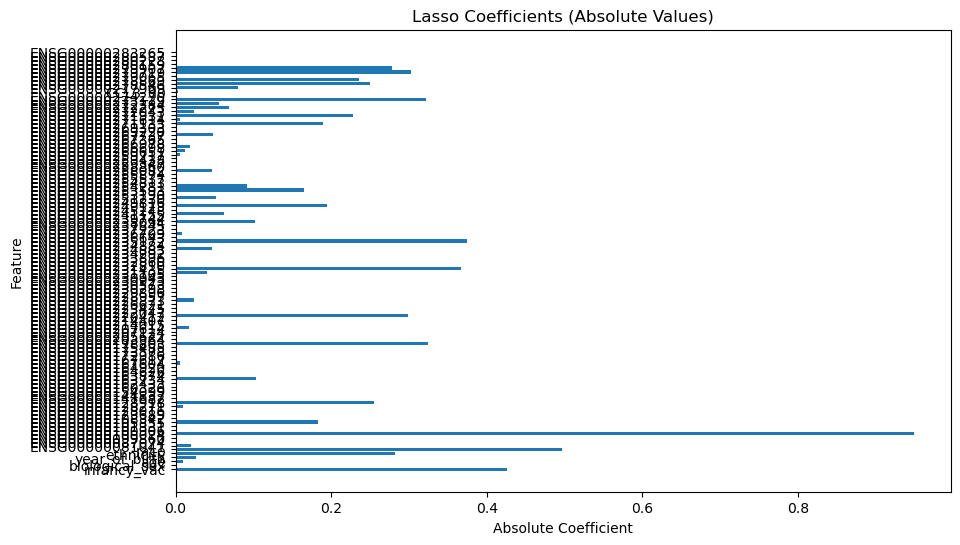

In [126]:
# Use Lasso Regression to select features
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train_scaled, y_train)
lasso_coefficients = lasso_model.coef_
selected_features = X_train_scaled.columns[lasso_coefficients != 0]
X_train_scaled_selected = X_train_scaled
X_test_scaled_selected = X_test_scaled

print("Selected Features:", selected_features)
print("Coefficients:", abs(lasso_coefficients))

plt.figure(figsize=(10, 6))
plt.barh(range(len(X_train_scaled.columns)), abs(lasso_coefficients), align="center")
plt.yticks(range(len(X_train_scaled.columns)), X_train_scaled.columns)
plt.xlabel('Absolute Coefficient')
plt.ylabel('Feature')
plt.title('Lasso Coefficients (Absolute Values)')
plt.show()

Selected Features: Index(['age', 'ENSG00000081041', 'ENSG00000100906', 'ENSG00000105855',
       'ENSG00000162433', 'ENSG00000205622', 'ENSG00000207124',
       'ENSG00000231435', 'ENSG00000234883', 'ENSG00000235172',
       'ENSG00000260651', 'ENSG00000272273', 'CCL3_d0', 'ENSG00000279907'],
      dtype='object')
Feature Importances: [2.05603931e-04 2.55832325e-03 6.20088461e-02 6.56888277e-03
 8.02250533e-03 6.99173340e-03 4.04363667e-02 6.26175732e-03
 9.80488201e-03 2.03366612e-03 1.65401737e-02 1.01352577e-02
 3.79750012e-02 6.74553044e-03 1.35365542e-02 4.20987531e-03
 1.17068585e-02 1.05522392e-02 1.20909991e-02 5.51732224e-03
 1.30970579e-02 7.28135730e-03 2.87117792e-02 1.33865918e-02
 3.17169454e-03 9.94870260e-03 1.53813252e-03 5.83494620e-03
 5.70132699e-06 4.33854657e-03 1.05476444e-02 5.97287630e-03
 6.49099237e-03 1.26986692e-03 3.15531090e-02 6.47179736e-02
 3.60074199e-03 5.70457801e-03 9.42682427e-03 1.78418529e-03
 1.45723939e-02 1.11563437e-02 2.33330324e-03 2.76329

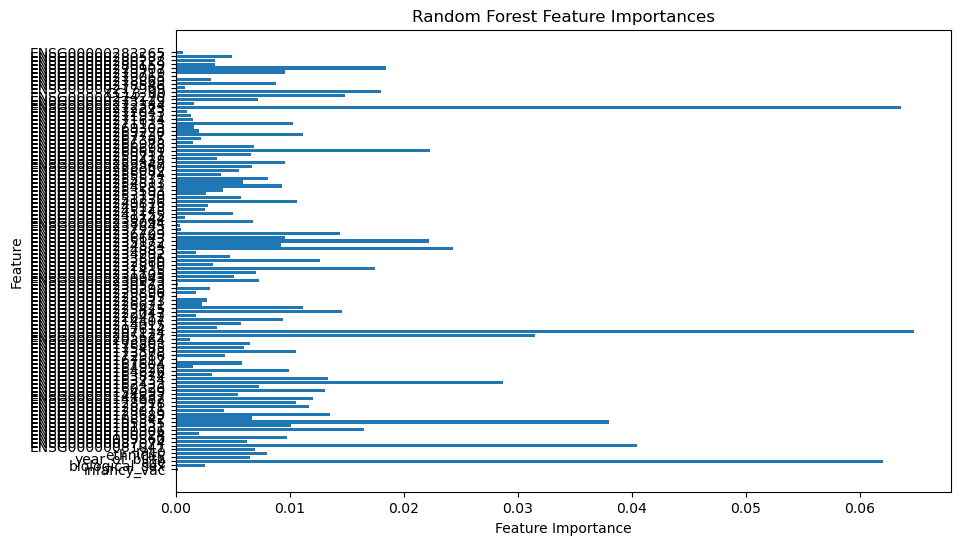

In [127]:
# Use Random Forest Regressor to select features
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)
feature_importances = rf_model.feature_importances_

threshold = 0.015
selected_features = X_train_scaled.columns[feature_importances > threshold]

X_train_scaled_selected = X_train_scaled
X_test_scaled_selected = X_test_scaled

print("Selected Features:", selected_features)
print("Feature Importances:", feature_importances)

plt.figure(figsize=(10, 6))
plt.barh(range(len(X_train_scaled.columns)), feature_importances, align="center")
plt.yticks(range(len(X_train_scaled.columns)), X_train_scaled.columns)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.show()


#### 3.6 Finding the best model

In [128]:
X_train, X_test, y_train, y_test = X,X,y,y

#train_test_split(X, y, test_size=0.2)
scaler = Normalizer()
X_train_scaled = X_train#pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = X_test#pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X_train_scaled_selected = X_train_scaled
X_test_scaled_selected = X_test_scaled

In [129]:
# Random Forest Regression
rf_model = RandomForestRegressor()
param_dist_rf = {
    'n_estimators': [10,30,40,50,100,200, 300, 400,500,600,700],
    'max_depth': [2,3, 4,5 ,6 ,7, 8, 9, 10,13,15,17,20],
    'min_samples_split': [5, 10, 15,17,18,19,20],
    'min_samples_leaf': [1, 2, 3]
}

# Randomized Search CV for Random Forest
random_search_rf = RandomizedSearchCV(rf_model,
                                      param_distributions=param_dist_rf, 
                                      n_iter=10, 
                                      scoring='r2',  
                                      cv=5, 
                                      random_state=42)
random_search_rf.fit(X_train_scaled_selected, y_train)

# Print best parameters for Random Forest
print("Random Forest - Best Parameters:", random_search_rf.best_params_)

# Evaluate Random Forest on the test set using R-squared
y_pred_rf = random_search_rf.predict(X_test_scaled_selected)
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest - R-squared on Test Set:", r2_rf)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled_selected, y_train)

# Evaluate Linear Regression on the test set using R-squared
y_pred_lr = lr_model.predict(X_test_scaled_selected)
r2_lr = r2_score(y_test, y_pred_lr)
print("Linear Regression - R-squared on Test Set:", r2_lr)

# Support Vector Regression
svr_model = SVR()
param_dist_svr = {
    'C': [5, 10, 15],
    'kernel': ['linear', 'rbf']
}

# Randomized Search CV for SVR

#random_search_svr = RandomizedSearchCV(svr_model, param_distributions=param_dist_svr, n_iter=5, scoring='r2', 
#                                       cv=5, random_state=42)
#random_search_svr.fit(X_train_scaled_selected, y_train)

# Print best parameters for SVR
#print("SVR - Best Parameters:", random_search_svr.best_params_)

# Evaluate SVR on the test set using R-squared
#y_pred_svr = random_search_svr.predict(X_test_scaled_selected)
#r2_svr = r2_score(y_test, y_pred_svr)
#print("SVR - R-squared on Test Set:", r2_svr)

# Gradient Boosting Regression
gb_model = GradientBoostingRegressor()
param_dist_gb = {
    'n_estimators': [35,36,37,38,39,40,41,42,43],
    'learning_rate': [0.001,0.01,0.02,0.03, 0.05, 0.08,0.1,0.2,0.5,1],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 3, 4,6,8,10,15,20],
    'min_samples_leaf': [1, 2, 3]
}

# Randomized Search CV for Gradient Boosting
random_search_gb = RandomizedSearchCV(gb_model, param_distributions=param_dist_gb, n_iter=10, scoring='r2',  
                                       cv=5, random_state=42)
random_search_gb.fit(X_train_scaled_selected, y_train)

# Print best parameters for Gradient Boosting
print("Gradient Boosting - Best Parameters:", random_search_gb.best_params_)

# Evaluate Gradient Boosting on the test set using R-squared
y_pred_gb = random_search_gb.predict(X_test_scaled_selected)
r2_gb = r2_score(y_test, y_pred_gb)
print("Gradient Boosting - R-squared on Test Set:", r2_gb)

# Lasso Regression
lasso_model = Lasso()
param_dist_lasso = {
    'alpha': [0.001, 0.01, 0.1, 1, 10]
}

# Randomized Search CV for Lasso
random_search_lasso = RandomizedSearchCV(lasso_model, param_distributions=param_dist_lasso, n_iter=5, scoring='r2', 
                                         cv=5, random_state=42)
random_search_lasso.fit(X_train_scaled_selected, y_train)

# Print best parameters for Lasso
print("Lasso - Best Parameters:", random_search_lasso.best_params_)

# Evaluate Lasso on the test set using R-squared
y_pred_lasso = random_search_lasso.predict(X_test_scaled_selected)
r2_lasso = r2_score(y_test, y_pred_lasso)
print("Lasso - R-squared on Test Set:", r2_lasso)

# Ridge Regression
ridge_model = Ridge()
param_dist_ridge = {
    'alpha': [0.001, 0.01, 0.1, 1, 10]
}

# Randomized Search CV for Ridge
random_search_ridge = RandomizedSearchCV(ridge_model, param_distributions=param_dist_ridge, n_iter=5, scoring='r2', 
                                         cv=5, random_state=42)
random_search_ridge.fit(X_train_scaled_selected, y_train)

# Print best parameters for Ridge
print("Ridge - Best Parameters:", random_search_ridge.best_params_)

# Evaluate Ridge on the test set using R-squared
y_pred_ridge = random_search_ridge.predict(X_test_scaled_selected)
r2_ridge = r2_score(y_test, y_pred_ridge)
print("Ridge - R-squared on Test Set:", r2_ridge)

# ElasticNet Regression
elasticnet_model = ElasticNet()
param_dist_elasticnet = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Randomized Search CV for ElasticNet
random_search_elasticnet = RandomizedSearchCV(elasticnet_model, param_distributions=param_dist_elasticnet, n_iter=10, scoring='r2', 
                                               cv=5, random_state=42)
random_search_elasticnet.fit(X_train_scaled_selected, y_train)

# Print best parameters for ElasticNet
print("ElasticNet - Best Parameters:", random_search_elasticnet.best_params_)

# Evaluate ElasticNet on the test set using R-squared
y_pred_elasticnet = random_search_elasticnet.predict(X_test_scaled_selected)
r2_elasticnet = r2_score(y_test, y_pred_elasticnet)
print("ElasticNet - R-squared on Test Set:", r2_elasticnet)

# Decision Tree Regression
dt_model = DecisionTreeRegressor()
param_dist_dt = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10,15,20],
    'min_samples_leaf': [1, 2, 4,6,8,10,15,20,25,30,35]
}

# Randomized Search CV for Decision Tree
random_search_dt = RandomizedSearchCV(dt_model, param_distributions=param_dist_dt, n_iter=5, scoring='r2', 
                                      cv=5, random_state=42)
random_search_dt.fit(X_train_scaled_selected, y_train)

# Print best parameters for Decision Tree
print("Decision Tree - Best Parameters:", random_search_dt.best_params_)

# Evaluate Decision Tree on the test set using R-squared
y_pred_dt = random_search_dt.predict(X_test_scaled_selected)
r2_dt = r2_score(y_test, y_pred_dt)
print("Decision Tree - R-squared on Test Set:", r2_dt)

# K-Nearest Neighbors Regression
knn_model = KNeighborsRegressor()
param_dist_knn = {
    'n_neighbors': np.arange(1, 20),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Randomized Search CV for KNN
random_search_knn = RandomizedSearchCV(knn_model, param_distributions=param_dist_knn, n_iter=10, scoring='r2', 
                                        cv=5, random_state=42)
random_search_knn.fit(X_train_scaled_selected, y_train)

# Print best parameters for KNN
print("KNN - Best Parameters:", random_search_knn.best_params_)

# Evaluate KNN on the test set using R-squared
y_pred_knn = random_search_knn.predict(X_test_scaled_selected)
r2_knn = r2_score(y_test, y_pred_knn)
print("KNN - R-squared on Test Set:", r2_knn)

# Compare r2 of different models
r2_dict = {'Random Forest': r2_rf, 'Linear Regression': r2_lr, 'Gradient Boosting': r2_gb,
            'Lasso': r2_lasso, 'Ridge': r2_ridge, 'ElasticNet': r2_elasticnet, 
            'Decision Tree': r2_dt, 'KNN': r2_knn}

# Find the model with the highest r2
best_model_name = max(r2_dict, key=r2_dict.get)
best_model = None

# Select the best model
if best_model_name == 'Random Forest':
    best_model = random_search_rf
elif best_model_name == 'Linear Regression':
    best_model = lr_model
#elif best_model_name == 'SVR':
#    best_model = random_search_svr
elif best_model_name == 'Gradient Boosting':
    best_model = random_search_gb
elif best_model_name == 'Lasso':
    best_model = random_search_lasso
elif best_model_name == 'Ridge':
    best_model = random_search_ridge
elif best_model_name == 'ElasticNet':
    best_model = random_search_elasticnet
elif best_model_name == 'Decision Tree':
    best_model = random_search_dt
elif best_model_name == 'KNN':
    best_model = random_search_knn

print(f"\nBest Model: {best_model_name} with R-squared: {r2_dict[best_model_name]}")

Random Forest - Best Parameters: {'n_estimators': 400, 'min_samples_split': 19, 'min_samples_leaf': 2, 'max_depth': 7}
Random Forest - R-squared on Test Set: 0.7231769521832092
Linear Regression - R-squared on Test Set: 1.0
Gradient Boosting - Best Parameters: {'n_estimators': 40, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_depth': 2, 'learning_rate': 0.01}
Gradient Boosting - R-squared on Test Set: 0.30676571645078243
Lasso - Best Parameters: {'alpha': 10}
Lasso - R-squared on Test Set: 0.5137668128685573
Ridge - Best Parameters: {'alpha': 10}
Ridge - R-squared on Test Set: 0.9215867669594008


/Users/brian/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.277e+00, tolerance: 1.447e-02

/Users/brian/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.792e-01, tolerance: 1.493e-02

/Users/brian/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.195e+00, tolerance: 8.791e-03

/Users/brian/anaconda3/lib/python3.11/si

ElasticNet - Best Parameters: {'l1_ratio': 0.7, 'alpha': 10}
ElasticNet - R-squared on Test Set: 0.5504147738194498
Decision Tree - Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 35, 'max_depth': 30}
Decision Tree - R-squared on Test Set: 0.10468246735483044
KNN - Best Parameters: {'weights': 'distance', 'n_neighbors': 16, 'metric': 'manhattan'}
KNN - R-squared on Test Set: 1.0

Best Model: Linear Regression with R-squared: 1.0


In [130]:
r2_dict

{'Random Forest': 0.7231769521832092,
 'Linear Regression': 1.0,
 'Gradient Boosting': 0.30676571645078243,
 'Lasso': 0.5137668128685573,
 'Ridge': 0.9215867669594008,
 'ElasticNet': 0.5504147738194498,
 'Decision Tree': 0.10468246735483044,
 'KNN': 1.0}

In [131]:
mods = list(r2_dict.keys())
og = list(r2_dict.values())

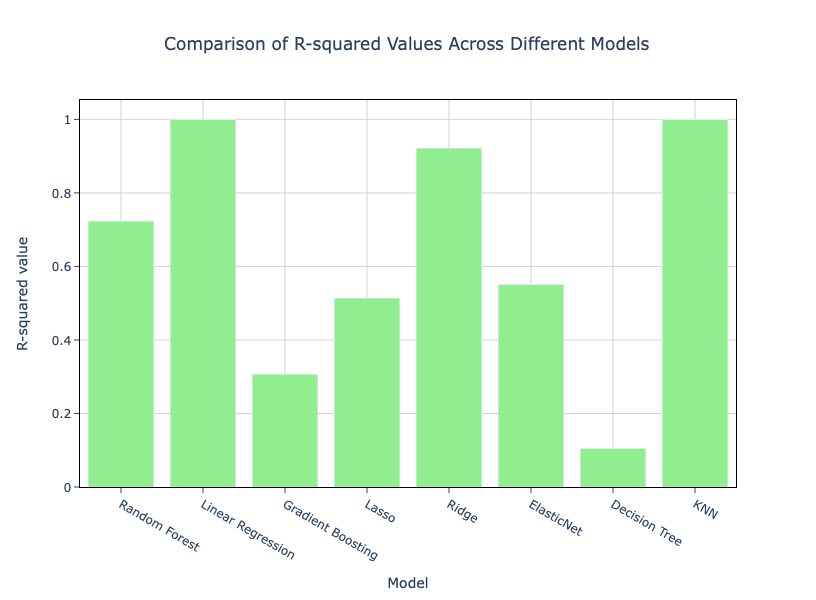

In [132]:
import plotly.graph_objects as px
plot = px.Figure(data=[
                       px.Bar(
    name = 'Original Model',
    x = mods,
    y = og
   )
])

plot.update_layout(title= 'Comparison of R-squared Values Across Different Models', title_x=0.5, 
                   xaxis_title = 'Model', yaxis_title='R-squared value',
                  width=800,height=600, plot_bgcolor= 'rgba(0, 0, 0, 0)',)
#paper_bgcolor= 'rgba(0, 0, 0, 0)',)
plot.update_traces(marker_color = 'LightGreen')
plot.update_xaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)
plot.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)
#plot.update_xaxes('Regression Model Type')
plot.show()



## 4. 2022 Validation Predictions

#### 4.1 Loading in 2022 prediction datasets: gene expression, specimen, and subject

In [54]:
gene_pred = clean_df_gene(df_2022_gene)

In [55]:
genes_cols_pred = gene_pred.pivot_table(index=['specimen_id'], columns=['versioned_ensembl_gene_id'], values= 'tpm')

In [57]:
final_gene_pred = genes_cols_pred[genes_cols_pred.columns.intersection(top100)].rename(columns= {'ENSG00000277632':'CCL3'}).reset_index()
final_gene_pred      

versioned_ensembl_gene_id,specimen_id,ENSG00000081041,ENSG00000087074,ENSG00000099860,ENSG00000100024,ENSG00000100906,ENSG00000101331,ENSG00000105855,ENSG00000108342,ENSG00000123689,...,ENSG00000277969,ENSG00000278546,ENSG00000278869,ENSG00000279065,ENSG00000279719,ENSG00000279907,ENSG00000280159,ENSG00000280228,ENSG00000280587,ENSG00000283265
0,730,12.099,43.599,34.308,0.297,690.221,0.195,0.349,0.0,1024.836,...,3.184,0.0,0.287,0.0,6.104,0.000,0.000,2.802,0.0,0.0
1,731,15.027,73.589,38.962,0.433,428.681,0.000,0.550,0.0,419.564,...,3.308,0.0,0.279,0.0,8.376,0.000,0.000,0.950,0.3,0.0
2,732,2.533,91.600,41.671,0.373,443.053,0.000,0.613,0.0,168.211,...,4.965,0.0,0.000,0.0,0.601,0.000,0.347,0.109,0.0,0.0
3,740,7.106,90.012,60.879,0.380,617.237,0.000,0.341,0.0,385.634,...,4.501,0.0,0.368,0.0,7.361,0.000,0.000,0.000,0.0,0.0
4,741,45.599,277.284,130.457,1.025,1707.834,0.000,0.432,0.0,1182.833,...,5.887,0.0,1.401,0.0,10.502,0.000,0.000,1.059,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,921,6.308,100.652,35.186,0.418,498.448,0.000,0.624,0.0,299.392,...,5.358,0.0,0.000,0.0,0.674,0.000,0.584,0.245,0.0,0.0
59,922,7.201,84.186,50.520,0.284,626.025,0.000,0.484,0.0,229.406,...,4.200,0.0,0.880,0.0,0.550,0.000,0.000,1.396,0.0,0.0
60,930,15.420,102.040,57.233,0.330,421.639,0.000,0.222,0.0,321.797,...,5.849,0.0,0.425,0.0,7.971,0.000,0.307,0.000,0.0,0.0
61,931,22.262,121.436,76.949,0.316,649.780,0.000,0.627,0.0,741.853,...,4.937,0.0,0.699,0.0,4.364,0.000,0.000,0.396,0.0,0.0


In [58]:
subject_pred = clean_df_subject(pd.merge(df_2022_specimen,df_2022_subject, on= 'subject_id'))

In [59]:
subject_pred.merge(final_gene_pred, on='specimen_id', how = 'right')

,specimen_id,subject_id,actual_day_relative_to_boost,planned_day_relative_to_boost,specimen_type,visit,infancy_vac,biological_sex,ethnicity,race,...,ENSG00000277969,ENSG00000278546,ENSG00000278869,ENSG00000279065,ENSG00000279719,ENSG00000279907,ENSG00000280159,ENSG00000280228,ENSG00000280587,ENSG00000283265
0,730,97,-31,-30,Blood,1,wP,Male,Not Hispanic or Latino,White,...,3.184,0.0,0.287,0.0,6.104,0.000,0.000,2.802,0.0,0.0
1,731,97,-12,-15,Blood,2,wP,Male,Not Hispanic or Latino,White,...,3.308,0.0,0.279,0.0,8.376,0.000,0.000,0.950,0.3,0.0
2,732,97,0,0,Blood,3,wP,Male,Not Hispanic or Latino,White,...,4.965,0.0,0.000,0.0,0.601,0.000,0.347,0.109,0.0,0.0
3,740,98,-31,-30,Blood,3,wP,Female,Not Hispanic or Latino,White,...,4.501,0.0,0.368,0.0,7.361,0.000,0.000,0.000,0.0,0.0
4,741,98,-14,-15,Blood,4,wP,Female,Not Hispanic or Latino,White,...,5.887,0.0,1.401,0.0,10.502,0.000,0.000,1.059,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,921,117,-13,-15,Blood,2,aP,Female,Hispanic or Latino,More Than One Race,...,5.358,0.0,0.000,0.0,0.674,0.000,0.584,0.245,0.0,0.0
59,922,117,0,0,Blood,3,aP,Female,Hispanic or Latino,More Than One Race,...,4.200,0.0,0.880,0.0,0.550,0.000,0.000,1.396,0.0,0.0
60,930,118,-52,-30,Blood,1,aP,Male,Not Hispanic or Latino,Asian,...,5.849,0.0,0.425,0.0,7.971,0.000,0.307,0.000,0.0,0.0
61,931,118,-38,-15,Blood,2,aP,Male,Not Hispanic or Latino,Asian,...,4.937,0.0,0.699,0.0,4.364,0.000,0.000,0.396,0.0,0.0
